/Users/myueta/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Enter a comma-separated list of stock tickers:  AAPL,NKE,AMZN
How many days do you want to consider for our analysis?  252


[*********************100%%**********************]  3 of 3 completed


Enter weight for AAPL (0.0 to 0.99):  0.5
Enter weight for NKE (0.0 to 0.99):  0.25
Enter weight for AMZN (0.0 to 0.99):  0.25
Enter the number of simulations (ex.:10000):  10000
Enter the number of forecast days:  252
Enter the initial investment amount:  100


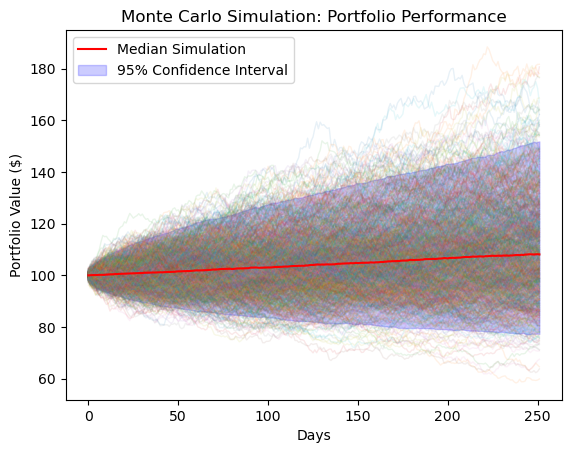


Summary Statistics:
50% Probability: Total >= $108.15. 
95% Probability: Total >= $81.90.
99% Probability: Total >= $72.87.
Profit Scenario: 67.93% of scenarios yield profit


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

# Input stock tickers
ticker_input = input("Enter a comma-separated list of stock tickers: ")
stock_list = [ticker.strip() for ticker in ticker_input.split(",")]

# Input historical data period
historical_data = int(input("How many days do you want to consider for our analysis? "))
date_final = dt.datetime.now()
date_initial = date_final - dt.timedelta(days=historical_data)

# Download historical stock prices
price = yf.download(stock_list, date_initial, date_final)['Adj Close']

# Calculate performance and covariance matrix
performance = price.pct_change().dropna()
covar_matrix = performance.cov()

# Input weights for each stock
weight_portfolio = []
for stock in stock_list:
    weight = float(input(f"Enter weight for {stock} (0.0 to 0.99): "))
    weight_portfolio.append(weight)
weight_portfolio = np.array(weight_portfolio) / sum(weight_portfolio)  # Normalize weights

# Input simulation parameters
simulations = int(input("Enter the number of simulations (ex.:10000): "))
forecast_days = int(input("Enter the number of forecast days: "))
initial_investment = float(input("Enter the initial investment amount: "))

# Generate random returns
performance_average = performance.mean(axis=0).to_numpy() 
performance_average_matrix = performance_average * np.ones(shape=(forecast_days, len(stock_list)))
L = LA.cholesky(covar_matrix)

performance_portfolio = np.zeros([forecast_days, simulations])
investment_final = np.zeros(simulations)

for s in range(simulations):
    Rpdf = np.random.normal(size=(forecast_days, len(stock_list))) 
    performance_random = performance_average_matrix + np.inner(Rpdf, L)
    performance_portfolio[:, s] = np.cumprod(np.inner(weight_portfolio, performance_random) + 1) * initial_investment
    investment_final[s] = performance_portfolio[-1, s]
    
# Plot a subset of simulation results
subset_size = 1000  # Change this value according to your preference
plt.plot(performance_portfolio[:, :subset_size], linewidth=1, alpha=0.1)  # Plot only the first 'subset_size' simulations

# Plot median simulation line
median_line = np.median(performance_portfolio, axis=1)
plt.plot(median_line, color='red', label='Median Simulation')

# Plot 95% confidence interval
confidence_interval = np.percentile(performance_portfolio, [2.5, 97.5], axis=1)
plt.fill_between(range(forecast_days), confidence_interval[0], confidence_interval[1], color='blue', alpha=0.2, label='95% Confidence Interval')

# Customize plot
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation: Portfolio Performance')
plt.legend()
plt.show()

# Compute and print summary statistics
total_99 = np.percentile(investment_final, 1)
total_95 = np.percentile(investment_final, 5)
total_median = np.percentile(investment_final, 50)
profit_scenario = (np.sum(investment_final > initial_investment) / simulations) * 100

print(f'''
Summary Statistics:
50% Probability: Total >= ${total_median:.2f}. 
95% Probability: Total >= ${total_95:.2f}.
99% Probability: Total >= ${total_99:.2f}.
Profit Scenario: {profit_scenario:.2f}% of scenarios yield profit''')


## Portfolio Maximum Drawdown

[*********************100%%**********************]  3 of 3 completed

Worst drawdown:
Lost: -13.00%
Period: 87 days
Initial date: 2023-07-31
Final date: 2023-10-26


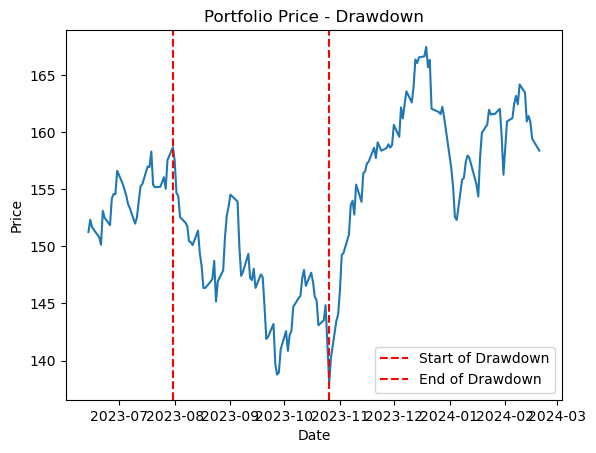

In [11]:
# Download historical stock prices
prices_data = yf.download(stock_list, date_initial, date_final)['Adj Close']

# Calculate portfolio value based on the weights
portfolio_value = (prices_data * weight_portfolio).sum(axis=1)

df = portfolio_value.reset_index()
df.columns=['Date','Price']

# Max_Cumul: Keep the highest value of Price
df['Max_Cumul'] = df['Price'].cummax()

# Drawdown: Calculate the drawdown for each day
df['Drawdown'] = (df['Price'] / df['Max_Cumul'])-1

# DD_initial_date: is the initial date of drawdown

## first line is the same date
df.loc[0,'DD_initial_date'] = df.loc[0,'Date']

## following date is the logic, if 'Max_Cumul' is different than previous, so the 'DD_initial_date' is change for current date, otherwise, keep the previous date
for i in range(1, len(df)):
    if df['Max_Cumul'].iloc[i] != df['Max_Cumul'].iloc[i - 1]:
        df.loc[i,'DD_initial_date'] = df.loc[i,'Date']
    else:
        df.loc[i,'DD_initial_date'] = df.loc[i-1,'DD_initial_date']

#Identifying the worst drawdown 
min_drawdown = df['Drawdown'].min()*100

# Summary

## identify the index of the worst drawdown
idx_min_drawdown = df['Drawdown'].idxmin()

## identify the dates
final_min_drawdown = df.loc[idx_min_drawdown, 'Date']
initial_min_drawdown = df.loc[idx_min_drawdown, 'DD_initial_date']
period_min_drawdown = final_min_drawdown-initial_min_drawdown

## printing the summary
print("Worst drawdown:")
print("Lost:", f"{min_drawdown:.2f}%")
print("Period:",period_min_drawdown.days,"days")
print("Initial date:", initial_min_drawdown.strftime('%Y-%m-%d'))
print("Final date:", final_min_drawdown.strftime('%Y-%m-%d'))

# Plotting

plt.plot(df['Date'], df['Price'])

plt.axvline(x=initial_min_drawdown, color='red', linestyle='--', label='Start of Drawdown')
plt.axvline(x=final_min_drawdown, color='red', linestyle='--', label='End of Drawdown')

plt.title('Portfolio Price - Drawdown')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()